In [17]:
import numpy as np
import matplotlib.pyplot as plt
import sipm.sipm as sipm
import sipm.dataset as ds
from scipy.optimize import curve_fit
from scipy.special import erfc, gamma
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [45]:
def gauss(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))

def line(x,a,b):
    return a*x+b

def line_vbd(x,a,vbd):
    return a*(x-vbd)

def compound_poisson(x,n,mu,p):
    k = [int(x_+0.5) for x_ in x]
    ans = []
    for k_ in k:
        if k_==0:
            ans.append(np.exp(-mu))
        else:
            ans_ = 0
            for i in range(1,k_+1):
                ans_ += gamma(k_+1)*gamma(k_)/gamma(i+1)/gamma(i)/gamma(k_-i+1)*(mu*(1-p))**i*p**(k_-i)
            ans.append(n*ans_*np.exp(-mu)/gamma(k_+1))
    return ans

# Top tile calibration (0928 data)

The 0928 datasets use laser pulses as the external trigger.

## Directories

In [4]:
data_dir = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/"
subdir = ['20220928_top_61V_laser_ext/',
          '20220928_top_63V_laser_ext/',
          '20220928_top_65V_laser_ext/',
          '20220928_top_67V_laser_ext/',
          '20220928_top_69V_laser_ext/']

## Process raw data and get:
* charge histograms
* filtered amplitude histograms
* average waveform

In [5]:
datasets = []
for subdir_ in subdir:
    avgwf_ch = []
    path = "{}{}".format(data_dir, subdir_)
    data = ds.Dataset(path, pol=-1, channels=range(4), samples=2048)
    for i in range(4):
        print(data.ch[i].file)
        data.ch[i].read_data(header=False)
        data.ch[i].baseline_subtraction()
        data.ch[i].get_integral(length=1.6)
        data.ch[i].get_integral_hist(min=0, max=5e3, nbins=1000)
        data.ch[i].ar_filter(tau=20)
        data.ch[i].get_ar_filtered_amp()
        data.ch[i].get_famp_hist(min=0, max=1e3, nbins=1000)
        data.ch[i].clear()
    datasets.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_top_61V_laser_ext/wave0.dat
WAVEFORM LENGTH = 2048 SAMPLES
TRIGGER POSITION = SAMPLE 816
NUMBER OF WAVEFORMS = 100000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_top_61V_laser_ext/wave1.dat
WAVEFORM LENGTH = 2048 SAMPLES
TRIGGER POSITION = SAMPLE 816
NUMBER OF WAVEFORMS = 100000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_top_61V_laser_ext/wave2.dat
WAVEFORM LENGTH = 2048 SAMPLES
TRIGGER POSITION = SAMPLE 815
NUMBER OF WAVEFORMS = 100000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_top_61V_laser_ext/wave3.dat
WAVEFORM LENGTH = 2048 SAMPLES
TRIGGER POSITION = SAMPLE 815
NUMBER OF WAVEFORMS = 100000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_top_63V_laser_ext/wave0.dat
WAVEFORM LENGTH = 2048 SAMPLES
TRIGGER POSITION = SAMPLE 816
NUMBER OF WAVEFORMS = 100000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022

## Plot charge histogram and analyze

Channel 0 Vbd=54.378+/-0.282V slope=43.893+/-1.126
Channel 1 Vbd=54.880+/-0.215V slope=39.983+/-0.820
Channel 2 Vbd=54.436+/-0.348V slope=41.399+/-1.316
Channel 3 Vbd=55.156+/-0.273V slope=41.417+/-1.105


Text(0.5, 0.98, 'Breakdown Voltage (Top)')

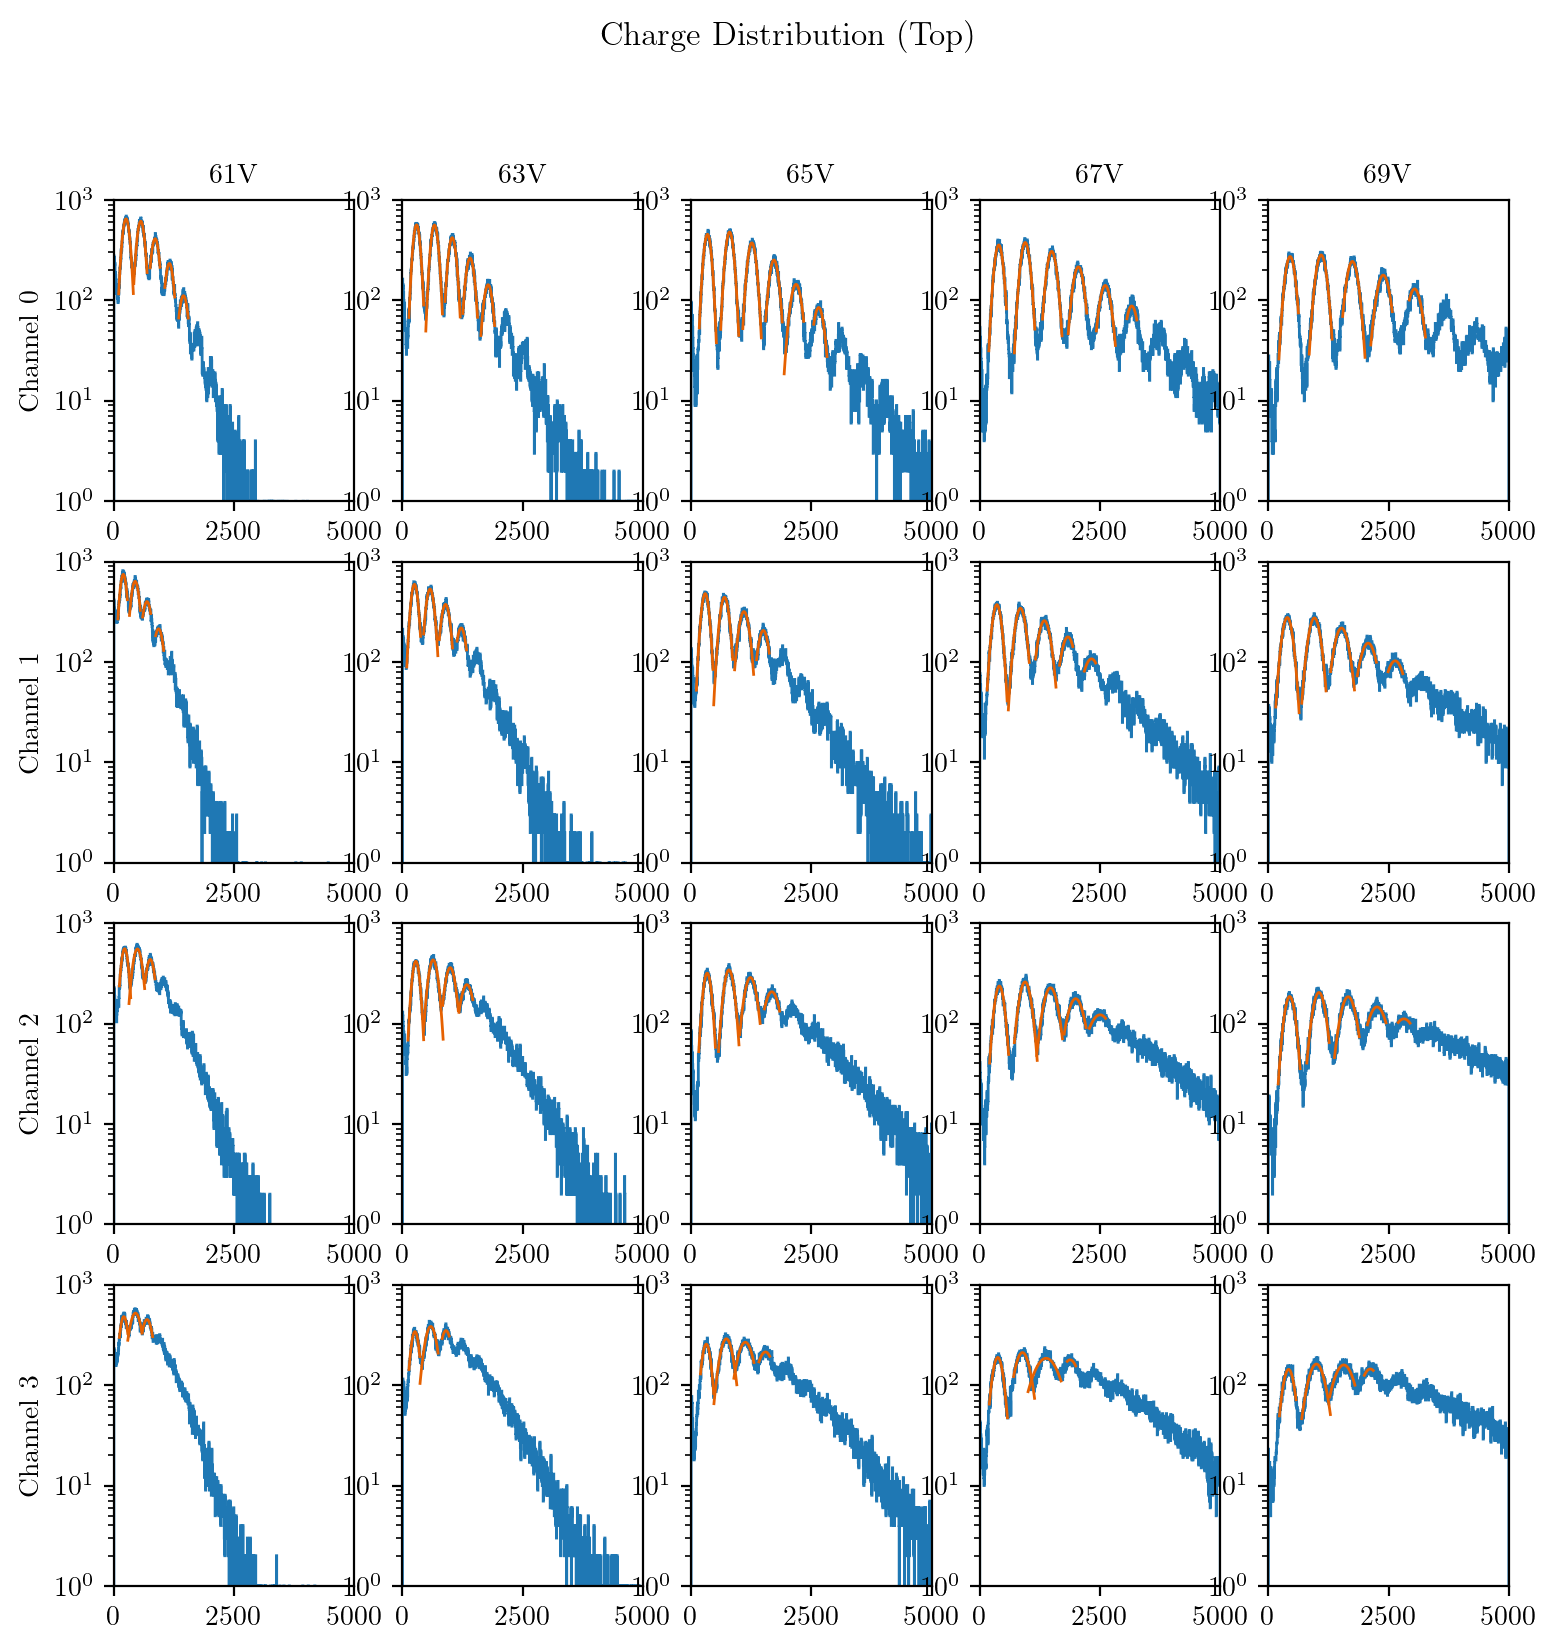

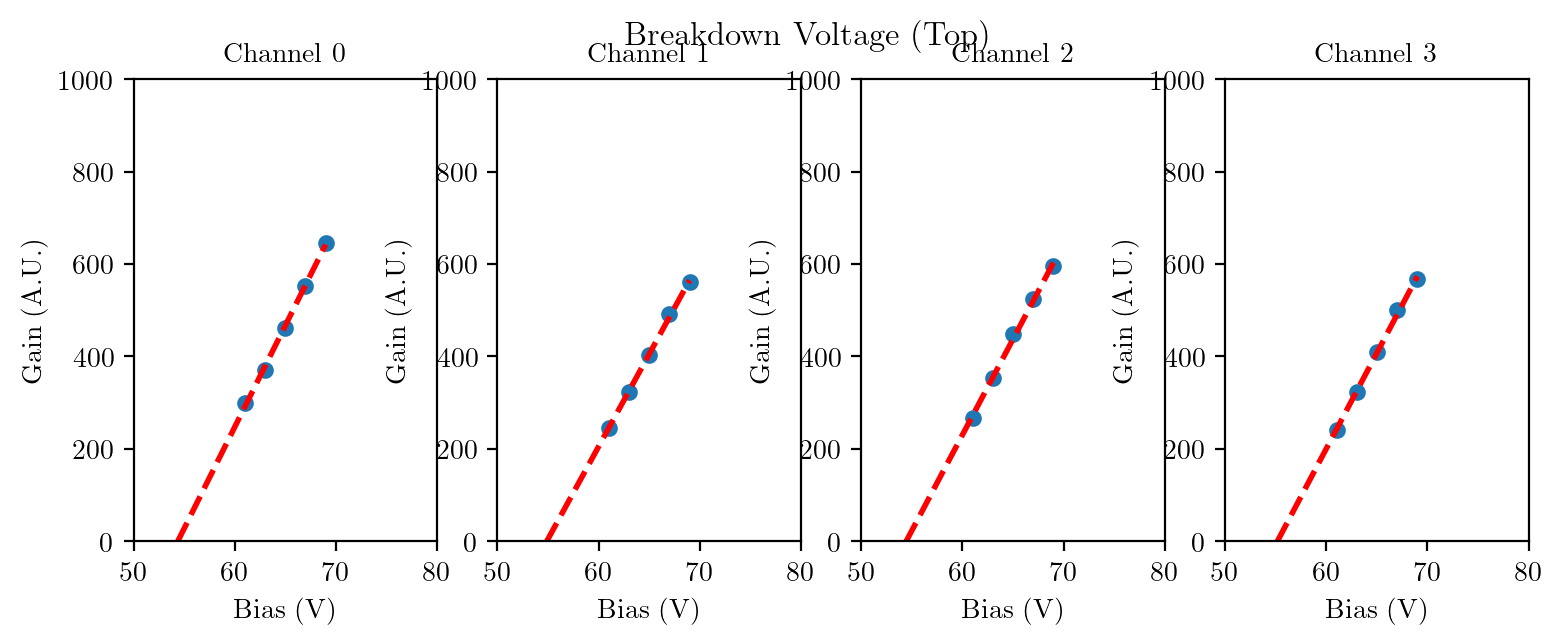

In [6]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [61, 63, 65, 67, 69]
Vbd_charge_top = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets): 
        #charge histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].integral_hist, data.ch[ch].integral_hist_bin)
        plt.yscale('log')
        plt.xlim(0, 5000)
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        thre = 20 #threshold to remove baseline noise
        peaks,pdict = find_peaks(data.ch[ch].integral_hist[thre:], prominence=60, width=15, distance=20)
        #fit pe peaks with Gaussian
        pe_mean = []
        bin_width = data.ch[ch].integral_hist_bin[1]-data.ch[ch].integral_hist_bin[0]
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + thre
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = bin_width*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = data.ch[ch].integral_hist_bin[0] + bin_width*min_bin
            max_x = data.ch[ch].integral_hist_bin[0] + bin_width*max_bin
            peak_x = data.ch[ch].integral_hist_bin[0] + bin_width*peak_bin
            popt,pcov = curve_fit(gauss, data.ch[ch].integral_hist_bin[min_bin:max_bin], data.ch[ch].integral_hist[min_bin:max_bin], p0=[data.ch[ch].integral_hist[peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(data.ch[ch].integral_hist_bin[min_bin:max_bin], gauss(data.ch[ch].integral_hist_bin[min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
            pe_mean.append(popt[1])
            if(ip==0):
                data.ch[ch].set_calibration(spe_integral=[popt[1]-2*popt[2],popt[1]+2*popt[2]])
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = pe_mean
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
        data.ch[ch].set_calibration(gain_integral=popt[0])
    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].gain_integral for data in datasets]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_charge_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)
        
plt.figure(0)
plt.suptitle('Charge Distribution (Top)')
# plt.savefig('../plots/sipm/charge_histo_top_0928.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Top)')
# plt.savefig('../plots/sipm/gain_bias_charge_top_0928.pdf')

## Plot filtered amplitude histogram and analyze

n=99789.66225483126 mu=1.931 p=0.082
n=100019.11092579816 mu=2.126 p=0.133
n=99189.63136381804 mu=2.279 p=0.171
n=99249.03116388182 mu=2.353 p=0.227
n=98467.16943287858 mu=2.424 p=0.286
Channel 0 Vbd=55.367+/-0.081V slope=9.531+/-0.077
n=99742.6842685734 mu=1.805 p=0.079
n=100792.44430861574 mu=1.973 p=0.137
n=101740.20261001668 mu=2.057 p=0.209
n=100818.71206078431 mu=2.129 p=0.245
n=97303.88713807943 mu=2.295 p=0.260
Channel 1 Vbd=55.197+/-0.085V slope=8.831+/-0.073
n=100225.64938918083 mu=2.241 p=0.098
n=100077.90334617872 mu=2.513 p=0.144
n=99062.63319513395 mu=2.702 p=0.182
n=99474.10007542356 mu=2.753 p=0.245
n=98690.3250726202 mu=2.881 p=0.297
Channel 2 Vbd=55.030+/-0.101V slope=8.871+/-0.086
n=99834.60871292255 mu=2.500 p=0.093
n=99897.2650273931 mu=2.754 p=0.149
n=99599.42513074254 mu=2.918 p=0.193
n=99466.2645293432 mu=3.039 p=0.253
n=99734.6949139114 mu=3.162 p=0.308
Channel 3 Vbd=55.149+/-0.081V slope=8.364+/-0.066


Text(0.5, 0.98, 'Breakdown Voltage (Top)')

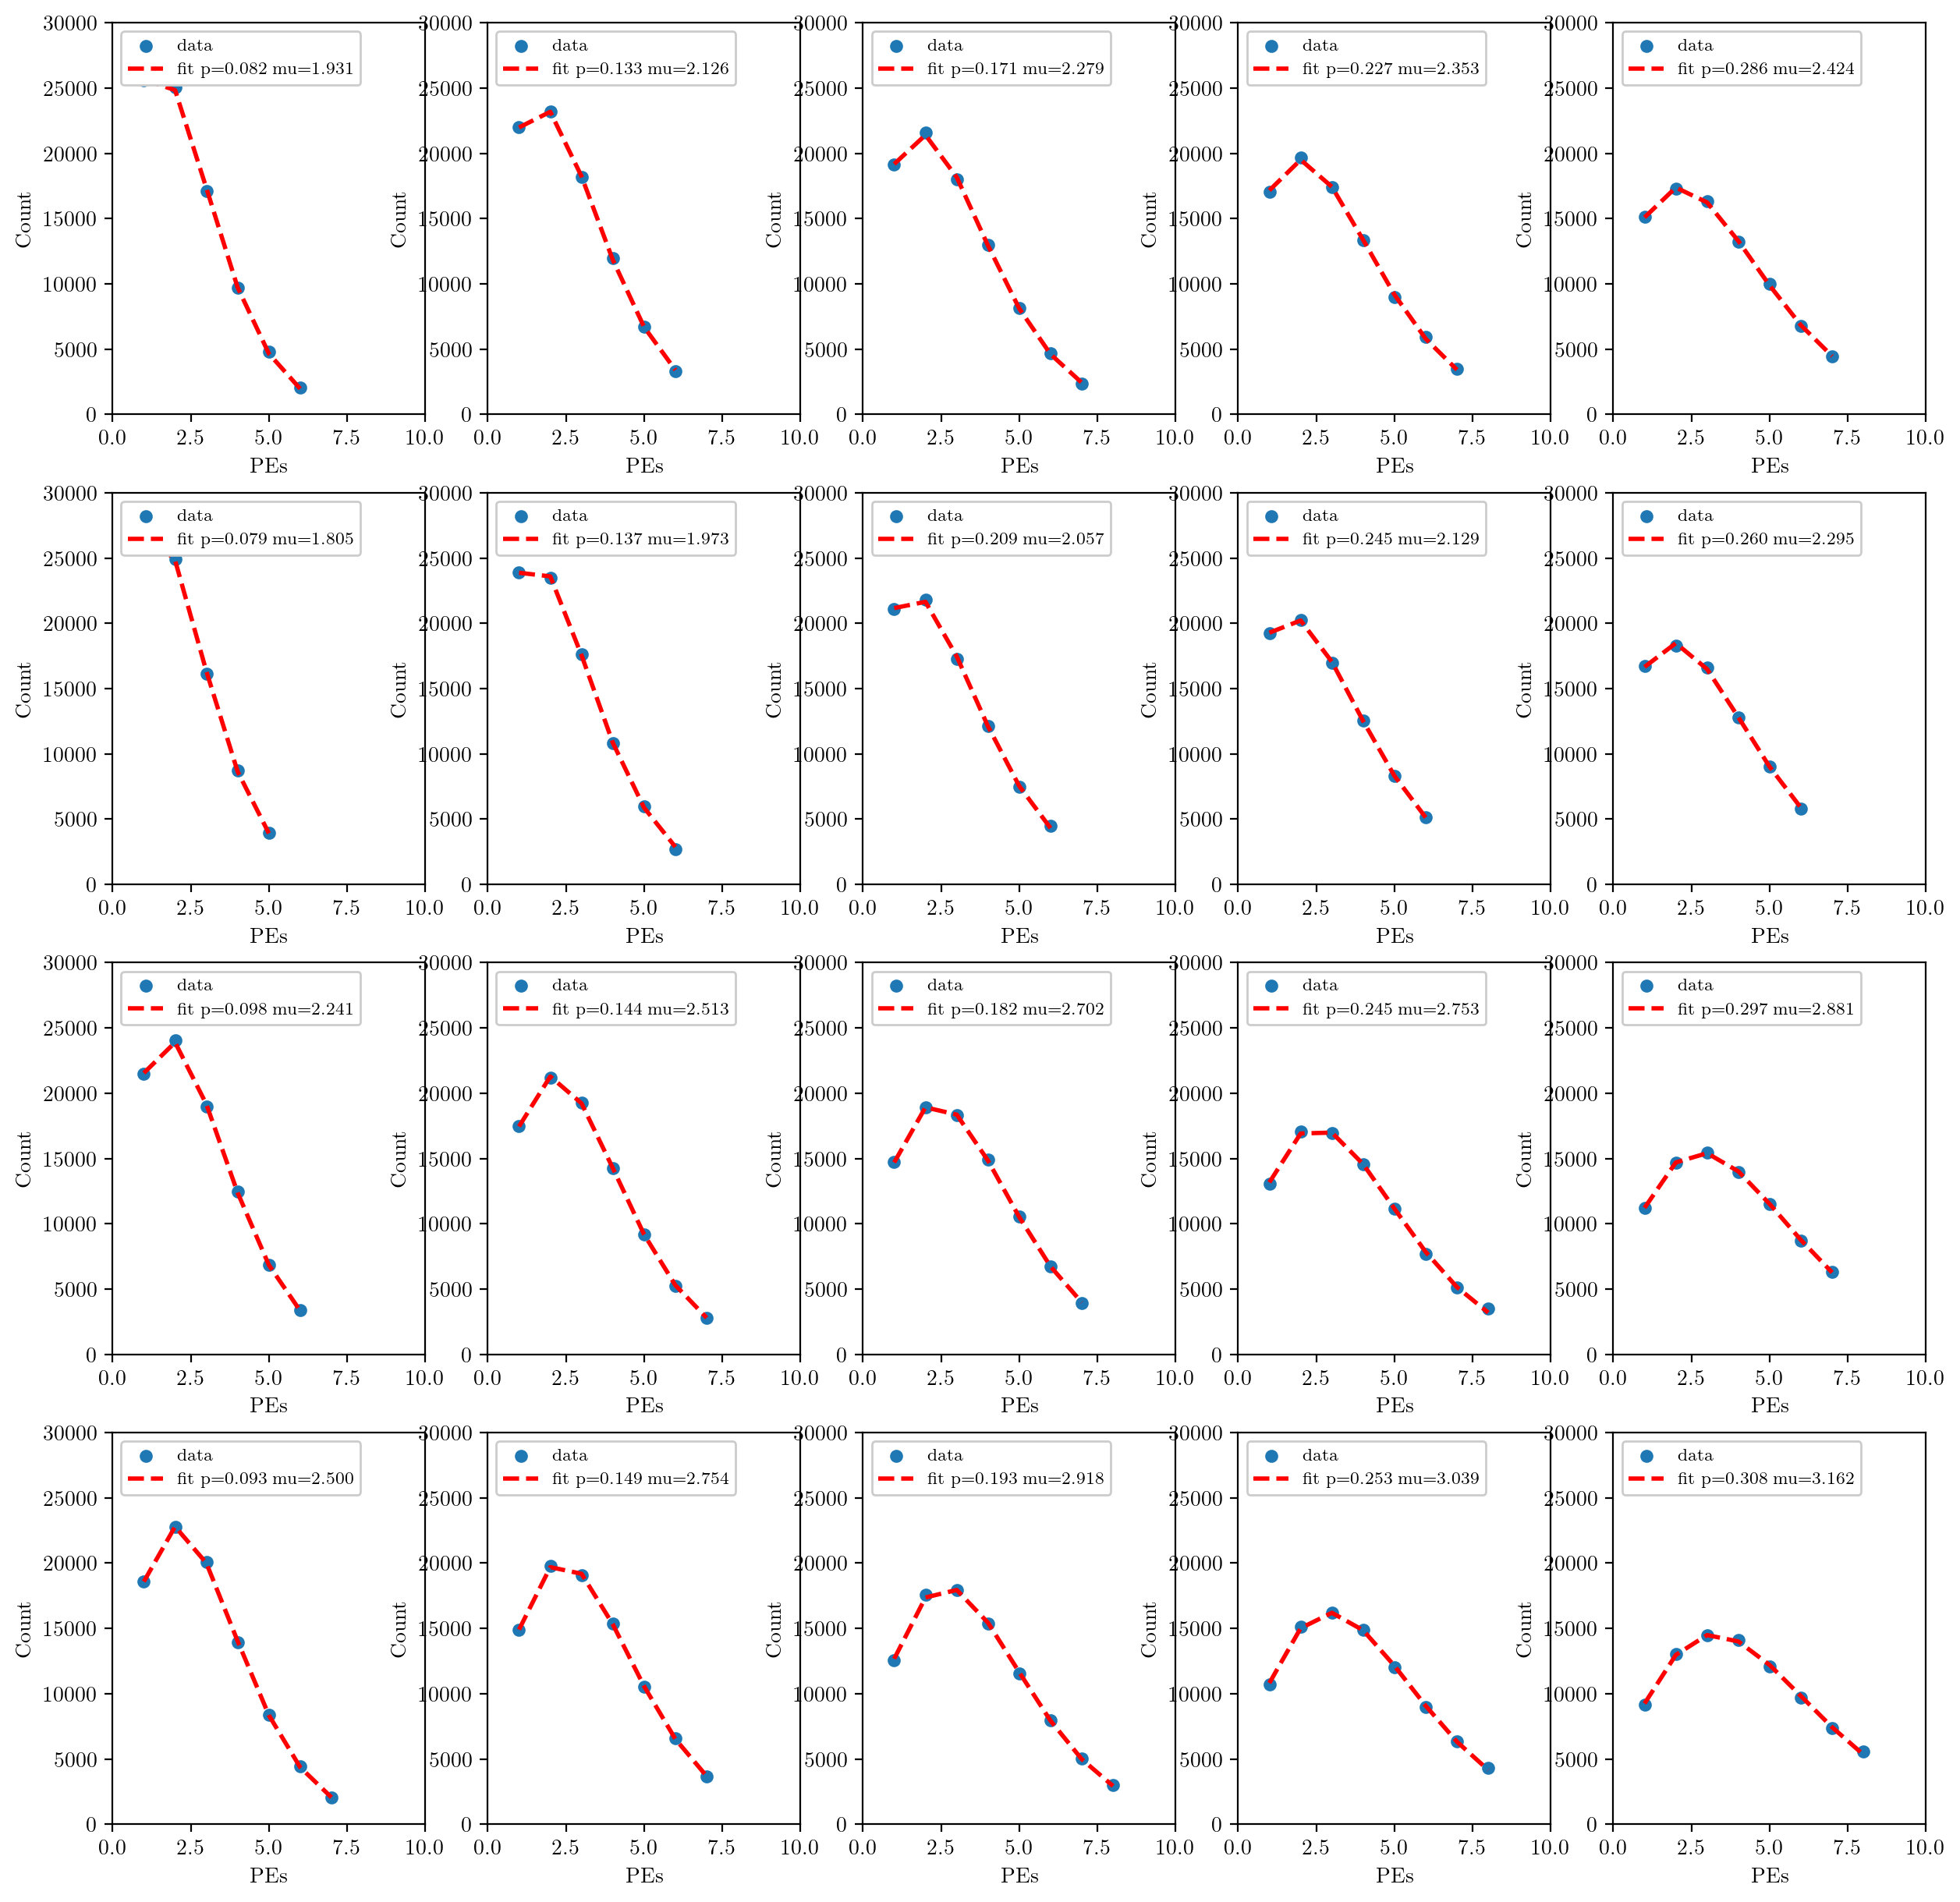

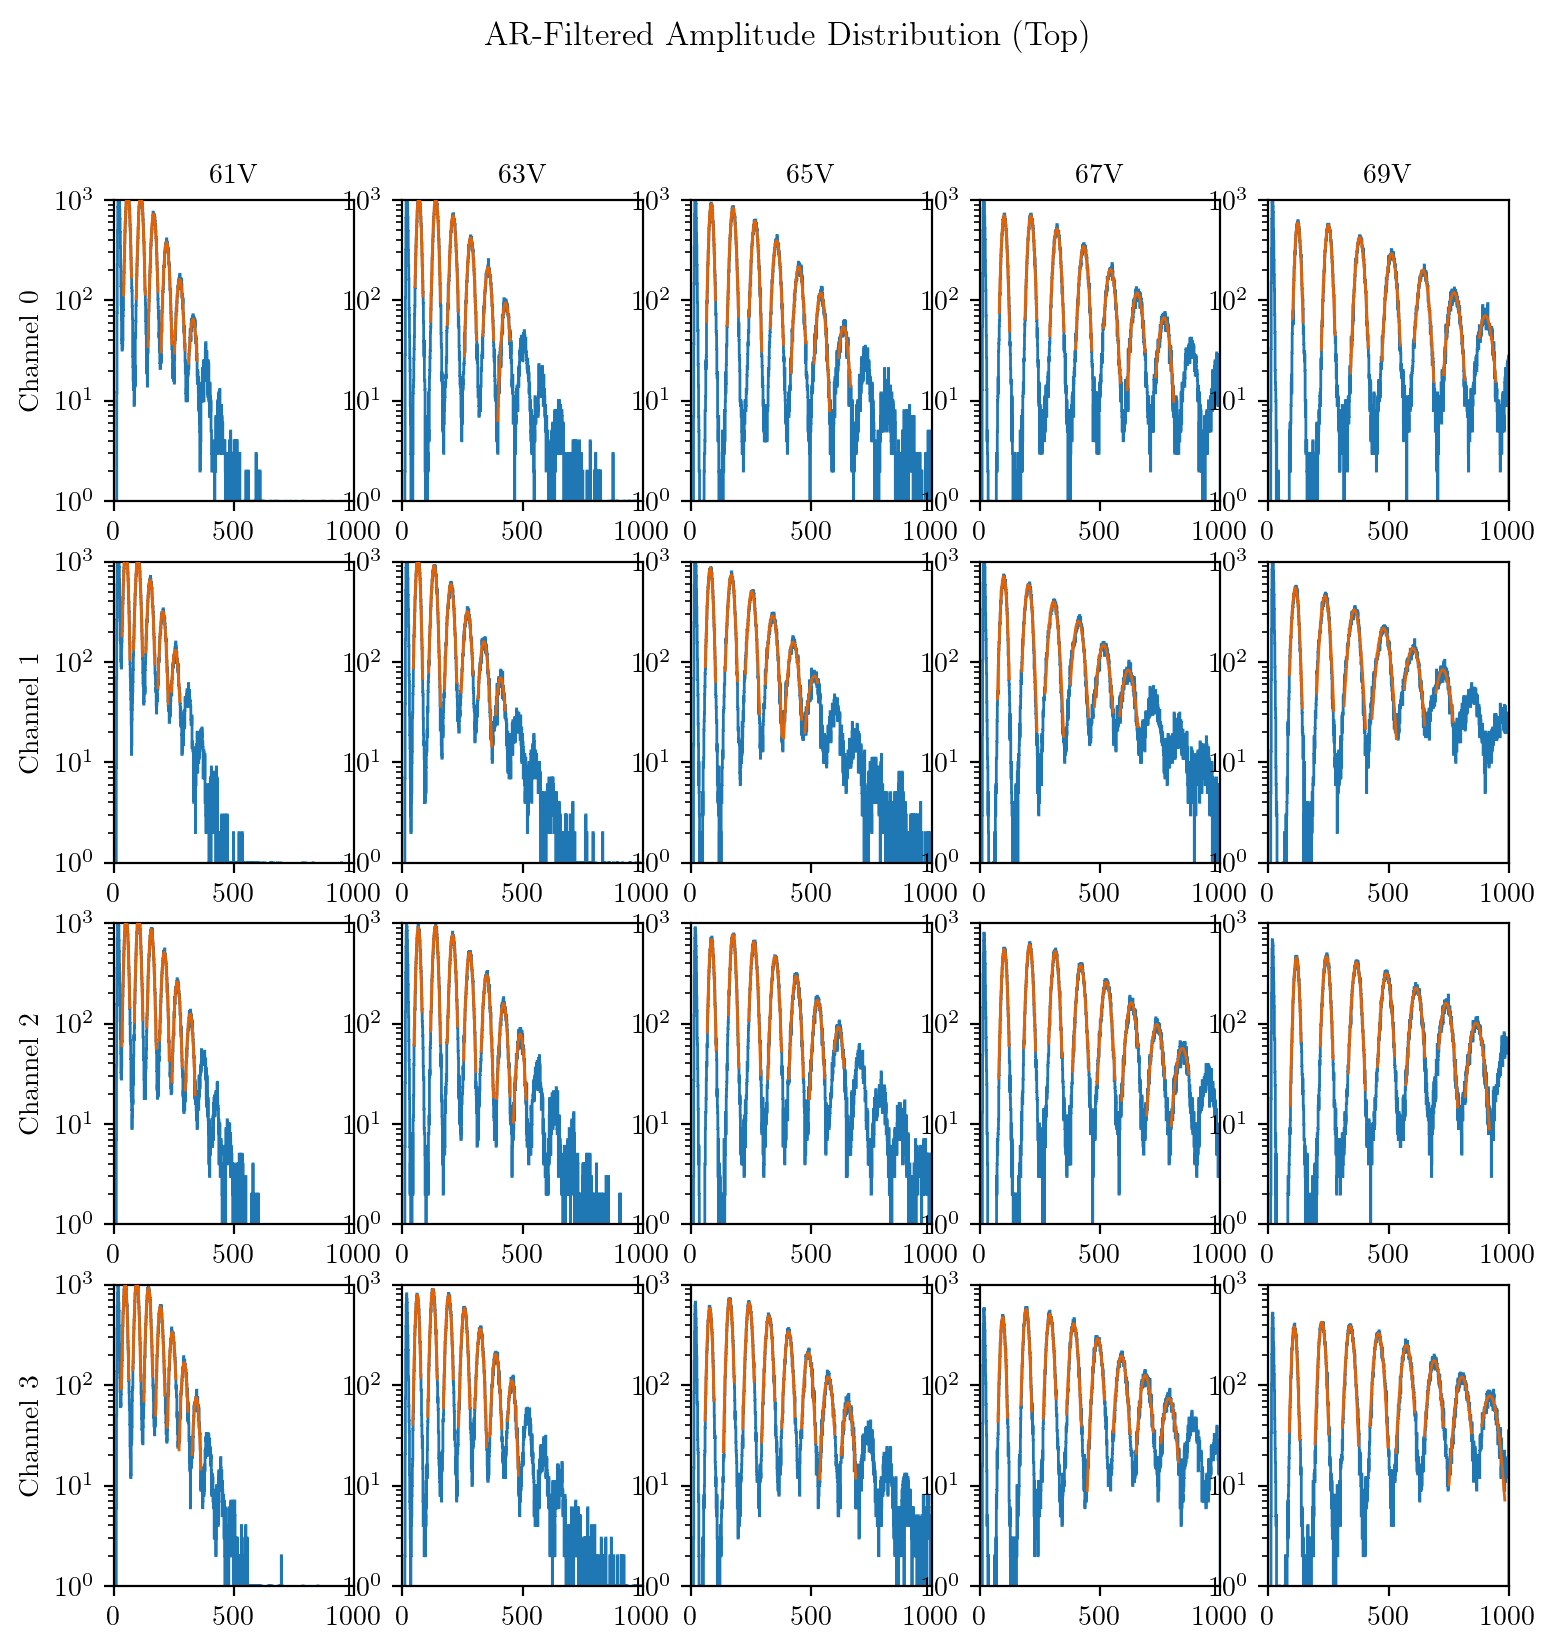

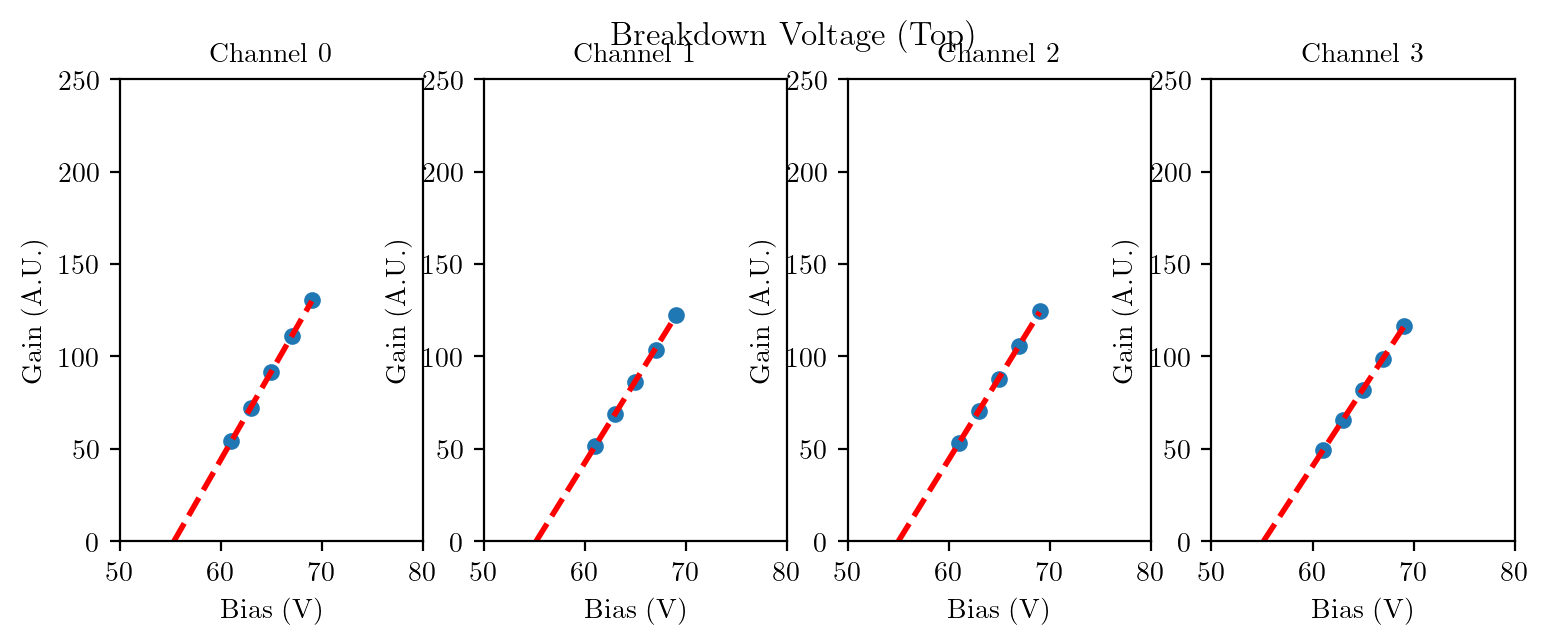

In [51]:
plt.figure(0,figsize=(9,9))#for filtered amplitude histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
plt.figure(2,figsize=(15,15))#for Vinogradov fit
bias = [61, 63, 65, 67, 69]
Vbd_famp_top = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets):  
        #filtered amplitude histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(0, 1000)
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        thre = 30
        peaks,pdict = find_peaks(data.ch[ch].famp_hist[thre:], prominence=60, width=15, distance=20)
        #fit pe peaks with Gaussian
        pe_mean = []
        pe_norm = []
        bin_width = data.ch[ch].famp_hist_bin[1]-data.ch[ch].famp_hist_bin[0]
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + thre
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = bin_width*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = data.ch[ch].famp_hist_bin[0] + bin_width*min_bin
            max_x = data.ch[ch].famp_hist_bin[0] + bin_width*max_bin
            peak_x = data.ch[ch].famp_hist_bin[0] + bin_width*peak_bin
            popt,pcov = curve_fit(gauss, data.ch[ch].famp_hist_bin[min_bin:max_bin], data.ch[ch].famp_hist[min_bin:max_bin], p0=[data.ch[ch].famp_hist[peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(data.ch[ch].famp_hist_bin[min_bin:max_bin], gauss(data.ch[ch].famp_hist_bin[min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
            pe_mean.append(popt[1])
            pe_norm.append(popt[0]*popt[2]*np.sqrt(2*np.pi))
            if(ip==0):
                data.ch[ch].set_calibration(spe_famp=[popt[1]-2*popt[2],popt[1]+2*popt[2]])
        
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = pe_mean
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
        data.ch[ch].set_calibration(gain_famp=popt[0])
        #Vinogradov fit
        plt.figure(2)
        plt.subplot(4,5,ch*5+i+1)
        plt.scatter(np.arange(1,len(pe_norm)+1), pe_norm, marker='.', label='data')
        popt,pcov = curve_fit(compound_poisson, list(np.arange(1,len(pe_norm)+1)), pe_norm, p0=[1e5, 2, 0.3], maxfev=10000)
        print('n={} mu={:.3f} p={:.3f}'.format(*popt))
        plt.plot(np.arange(1,len(pe_norm)+1), compound_poisson(np.arange(1,len(pe_norm)+1),*popt), 'r--', label='fit p={:.3f} mu={:.3f}'.format(popt[2],popt[1]))
        plt.ylim(0,3e4)
        plt.xlim(0,10)
        plt.xlabel('PEs')
        plt.ylabel('Count')
        plt.legend()

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].gain_famp for data in datasets]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_famp_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,250)
        
plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Top)')
# plt.savefig('../plots/sipm/famp_histo_top_0928.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Top)')
# plt.savefig('../plots/sipm/gain_bias_famp_top_0928.pdf')

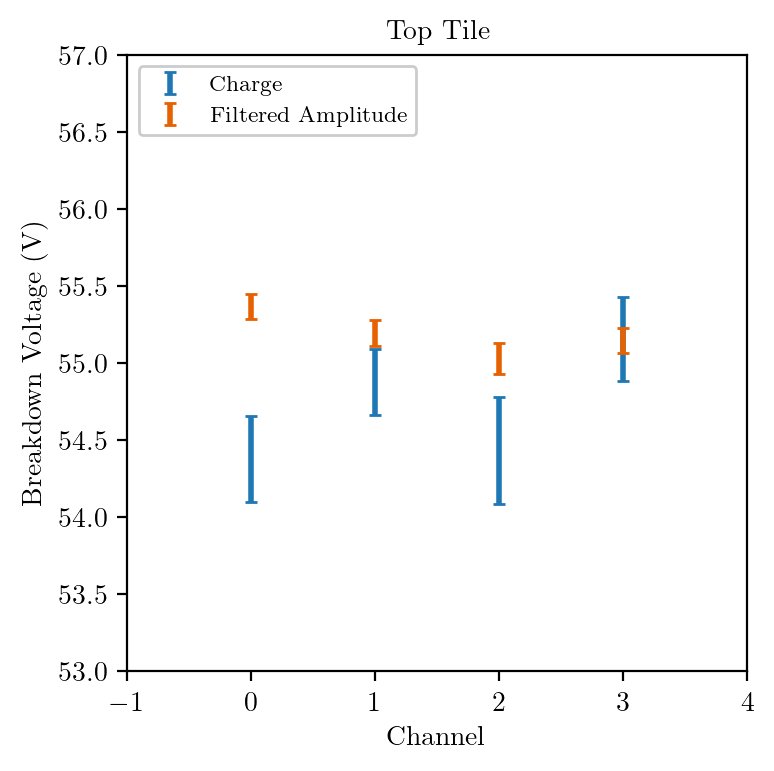

In [8]:
plt.figure(0,figsize=(4,4))
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_charge_top[:,0], yerr=Vbd_charge_top[:,1], label='Charge', ls='none')
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_famp_top[:,0], yerr=Vbd_famp_top[:,1], label='Filtered Amplitude', ls='none')
plt.xlim(-1,4)
plt.ylim(53,57)
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage (V)')
plt.title('Top Tile')
plt.legend()
plt.show()
# plt.savefig('../plots/sipm/vbd_top_0928.pdf')

## Examine after-pulses

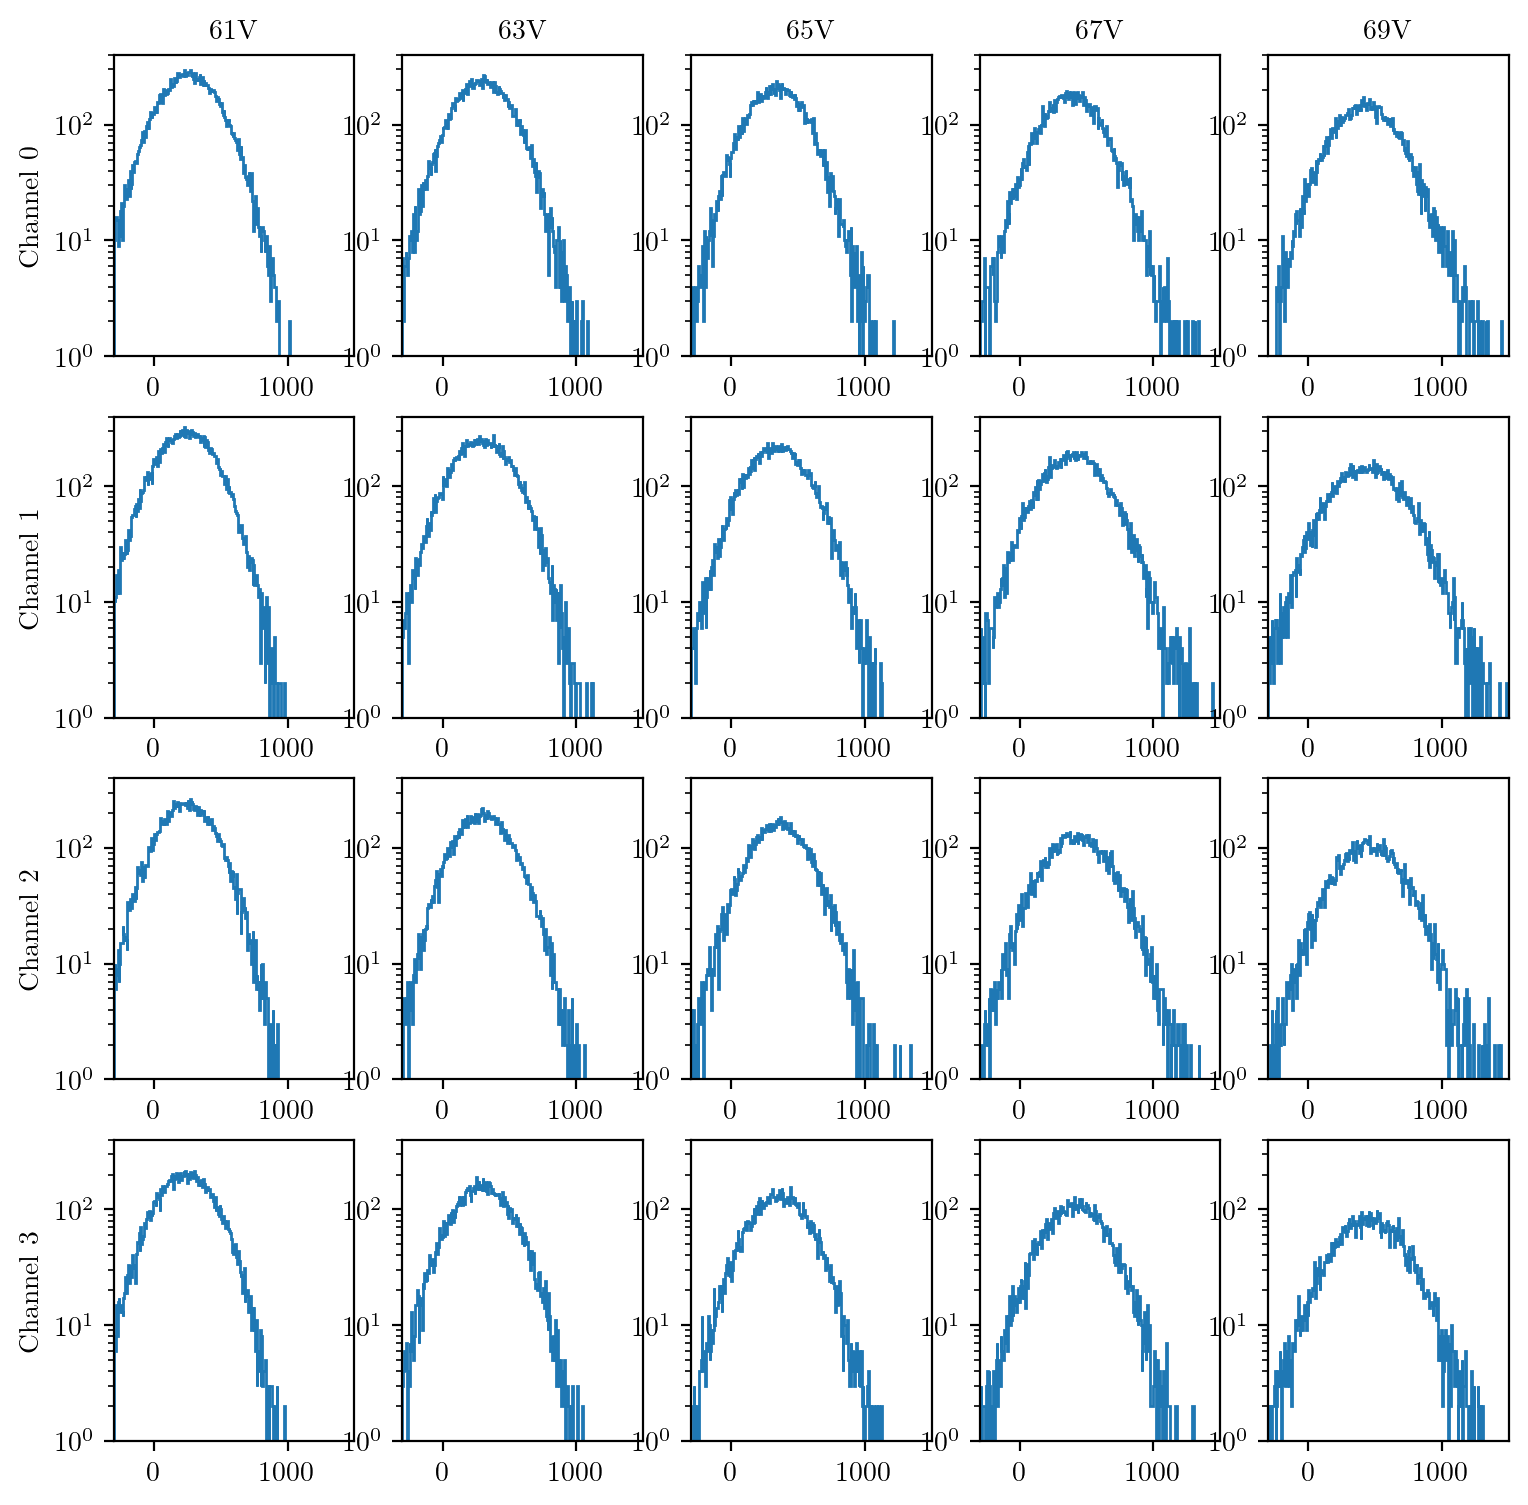

In [12]:
plt.figure(0,figsize=(9,9))

for ch in [0,1,2,3]:
    for i,data in enumerate(datasets):
        data.ch[ch].get_afterpulse_charge(xmin=-300,xmax=1500,nbins=300)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].ap_charge_hist, data.ch[ch].ap_charge_hist_bin)
        plt.xlim(data.ch[ch].ap_charge_hist_bin[0], data.ch[ch].ap_charge_hist_bin[-1])
        plt.ylim(1,4e2)
        plt.yscale('log')


## SPE average waveform

CH0 61V  A1=1.647 TAU1=0.07168us A2=2.123 TAU2=0.41463us INTEGRAL=249.596
CH0 63V  A1=2.015 TAU1=0.06163us A2=2.588 TAU2=0.39408us INTEGRAL=285.997
CH0 65V  A1=2.350 TAU1=0.05331us A2=3.412 TAU2=0.34460us INTEGRAL=325.283
CH0 67V  A1=3.030 TAU1=0.04796us A2=4.212 TAU2=0.31789us INTEGRAL=371.074
CH0 69V  A1=3.497 TAU1=0.05509us A2=5.126 TAU2=0.29038us INTEGRAL=420.272
CH1 61V  A1=2.696 TAU1=0.10429us A2=0.738 TAU2=0.83227us INTEGRAL=223.784
CH1 63V  A1=3.514 TAU1=0.10335us A2=0.946 TAU2=0.75625us INTEGRAL=269.558
CH1 65V  A1=4.464 TAU1=0.09480us A2=1.193 TAU2=0.67362us INTEGRAL=306.669
CH1 67V  A1=5.694 TAU1=0.10183us A2=1.350 TAU2=0.65211us INTEGRAL=365.092
CH1 69V  A1=6.261 TAU1=0.09249us A2=1.830 TAU2=0.53942us INTEGRAL=391.620
CH2 61V  A1=1.922 TAU1=0.07366us A2=1.712 TAU2=0.45859us INTEGRAL=231.635
CH2 63V  A1=2.371 TAU1=0.06439us A2=2.337 TAU2=0.40978us INTEGRAL=277.601
CH2 65V  A1=2.919 TAU1=0.06779us A2=2.925 TAU2=0.37612us INTEGRAL=324.455
CH2 67V  A1=3.264 TAU1=0.05595us A2=3.

Text(0.5, 0.98, 'SPE Average Waveform (Top)')

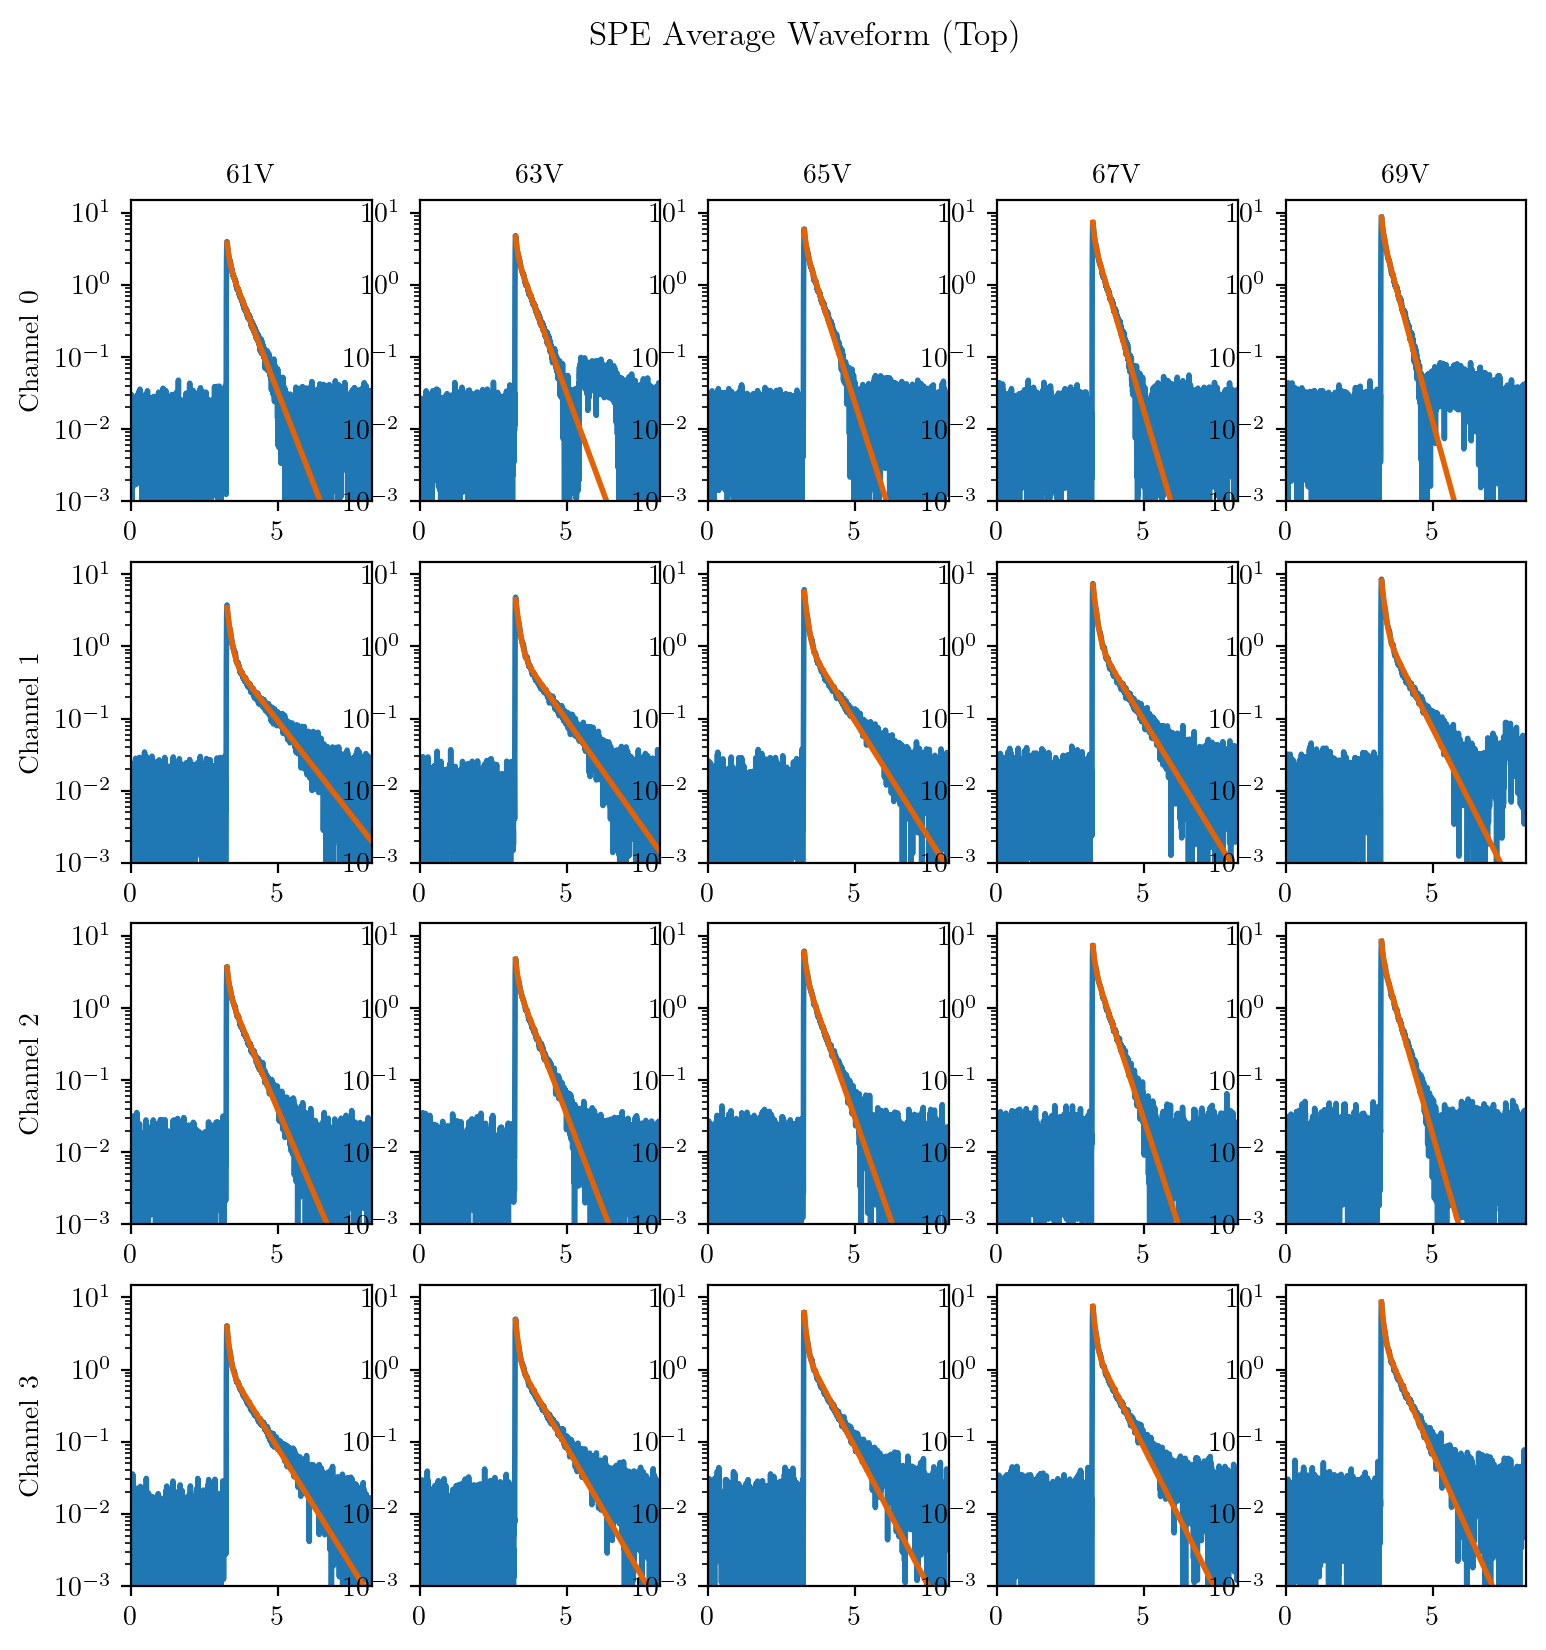

In [9]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))
bias = [61, 63, 65, 67, 69]
for ch in [0,1,2,3]:
    spe_integral = []
    for i,data in enumerate(datasets):
        data.ch[ch].get_spe_avgwf()
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(data.ch[ch].time, abs(data.ch[ch].spe_avgwf))
        popt,pcov = curve_fit(data.ch[ch].get_pulse_shape, data.ch[ch].time[data.ch[ch].trigger_position:], data.ch[ch].spe_avgwf[data.ch[ch].trigger_position:], p0=[3,0.08,3,0.5],maxfev=10000)
        plt.plot(data.ch[ch].time[data.ch[ch].trigger_position:], data.ch[ch].get_pulse_shape(data.ch[ch].time[data.ch[ch].trigger_position:],*popt))
        spe_integral.append(popt[0]*popt[1]*250+popt[2]*popt[3]*250)
        print('CH{} {}V  A1={:.3f} TAU1={:.5f}us A2={:.3f} TAU2={:.5f}us INTEGRAL={:.3f}'.format(ch,bias[i],popt[0],popt[1],popt[2],popt[3],popt[0]*popt[1]*250+popt[2]*popt[3]*250))
        data.ch[ch].set_pulse_shape(*popt)
        plt.xlim(data.ch[ch].time[0],data.ch[ch].time[-1])
        plt.ylim(1e-3, 15)
        plt.yscale('log')
    #breakdown voltage fit and plot
    xlin = bias
    ylin = spe_integral
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
plt.suptitle('SPE Average Waveform (Top)')
# plt.savefig('../plots/sipm/spewf_top_0928.pdf')

# Bottome tile calibration (0928 data)

## Directories

In [10]:
data_dir = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/"
subdir = ['20220928_bottom_61V_laser_ext/',
          '20220928_bottom_63V_laser_ext/',
          '20220928_bottom_65V_laser_ext/',
          '20220928_bottom_67V_laser_ext/',
          '20220928_bottom_69V_laser_ext/']

## Process raw data and get:
* charge histograms
* filtered amplitude histograms
* average waveform

In [11]:
datasets = []
for subdir_ in subdir:
    avgwf_ch = []
    path = "{}{}".format(data_dir, subdir_)
    data = ds.Dataset(path, pol=-1, channels=range(4), samples=2048)
    for i in range(4):
        print(data.ch[i].file)
        data.ch[i].read_data(header=False)
        data.ch[i].baseline_subtraction()
        data.ch[i].get_integral(length=1.6)
        data.ch[i].get_integral_hist(min=0, max=5e3, nbins=1000)
        data.ch[i].ar_filter(tau=20)
        data.ch[i].get_ar_filtered_amp()
        data.ch[i].get_famp_hist(min=0, max=1e3, nbins=1000)
        data.ch[i].clear()
    datasets.append(data)

/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_bottom_61V_laser_ext/wave0.dat
WAVEFORM LENGTH = 2048 SAMPLES
TRIGGER POSITION = SAMPLE 815
NUMBER OF WAVEFORMS = 100000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_bottom_61V_laser_ext/wave1.dat
WAVEFORM LENGTH = 2048 SAMPLES
TRIGGER POSITION = SAMPLE 815
NUMBER OF WAVEFORMS = 100000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_bottom_61V_laser_ext/wave2.dat
WAVEFORM LENGTH = 2048 SAMPLES
TRIGGER POSITION = SAMPLE 815
NUMBER OF WAVEFORMS = 100000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_bottom_61V_laser_ext/wave3.dat
WAVEFORM LENGTH = 2048 SAMPLES
TRIGGER POSITION = SAMPLE 815
NUMBER OF WAVEFORMS = 100000
/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-28/20220928_bottom_63V_laser_ext/wave0.dat
WAVEFORM LENGTH = 2048 SAMPLES
TRIGGER POSITION = SAMPLE 815
NUMBER OF WAVEFORMS = 100000
/scratch/gpfs/GALBIATI/data/sipm/reflect

## Plot charge histogram and analyze

Channel 0 Vbd=54.766+/-0.428V slope=39.327+/-1.584
ch0 gain@60V = 205.82353857375963
Channel 1 Vbd=55.099+/-0.298V slope=41.039+/-1.188
ch1 gain@60V = 201.11478860251896
Channel 2 Vbd=55.224+/-0.144V slope=37.207+/-0.527
ch2 gain@60V = 177.70098280933044
Channel 3 Vbd=54.624+/-0.244V slope=43.592+/-0.989
ch3 gain@60V = 234.3266508247796


/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 0.98, 'Breakdown Voltage (Bottom)')

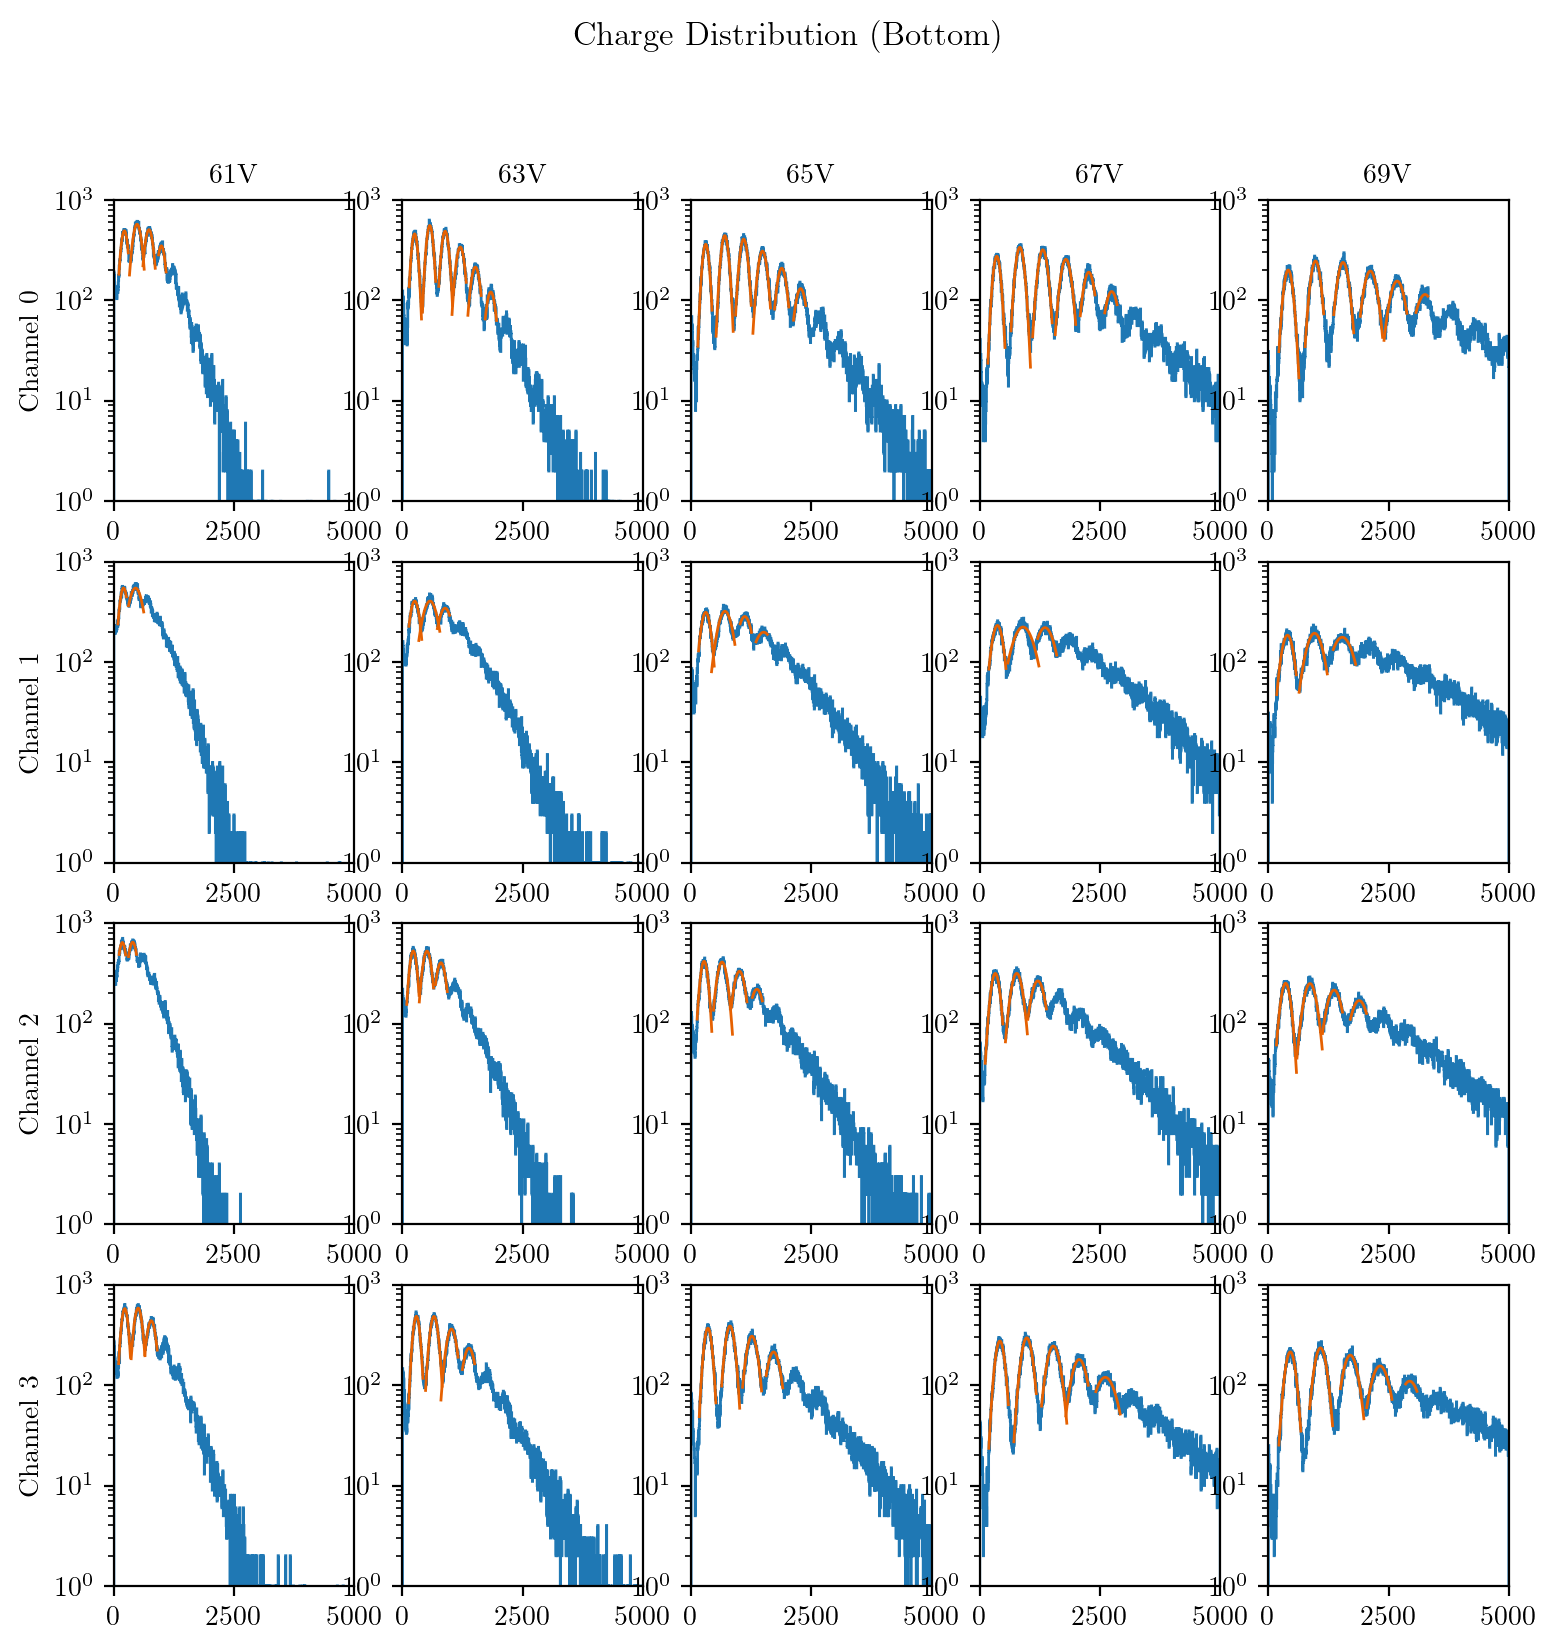

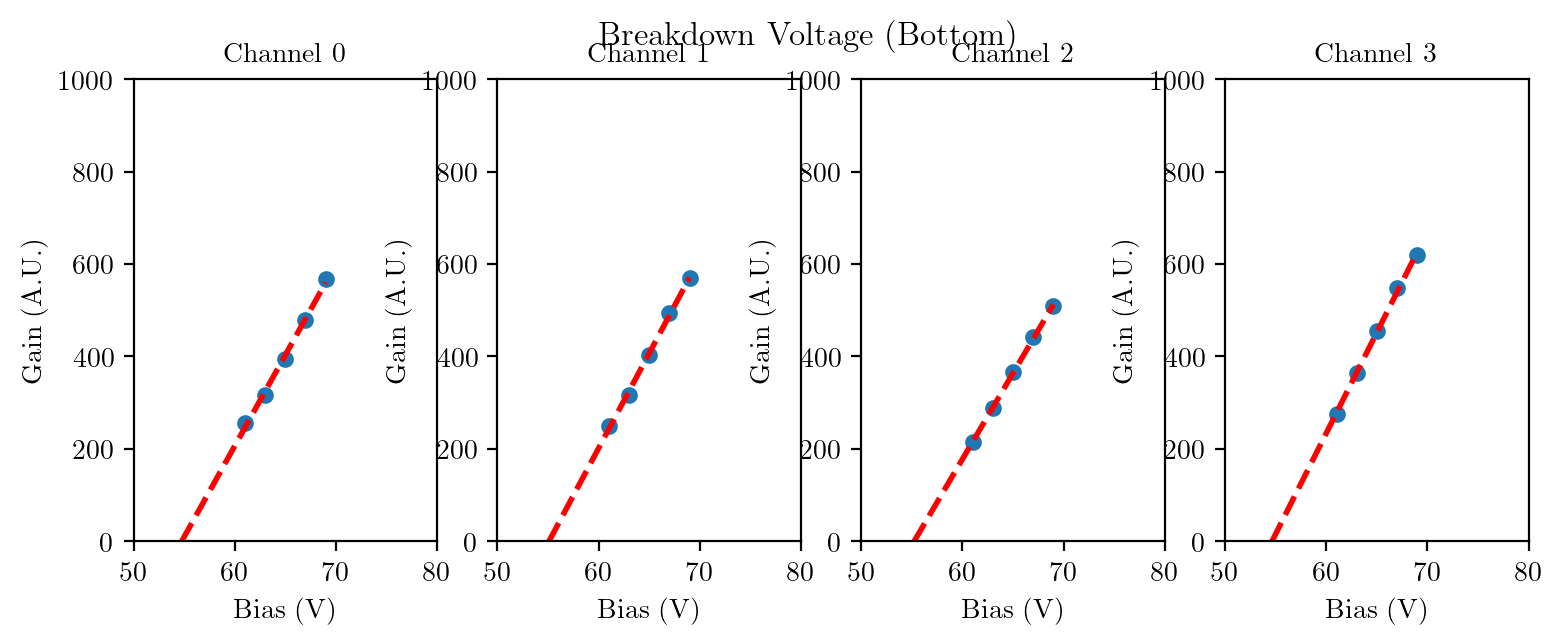

In [12]:
plt.figure(0,figsize=(9,9))#for charge histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [61, 63, 65, 67, 69]
Vbd_charge_bottom = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets): 
        #charge histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].integral_hist, data.ch[ch].integral_hist_bin)
        plt.yscale('log')
        plt.xlim(0, 5000)
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        thre = 20 #threshold to remove baseline noise
        peaks,pdict = find_peaks(data.ch[ch].integral_hist[thre:], prominence=60, width=13, distance=20)
        #fit pe peaks with Gaussian
        pe_mean = []
        bin_width = data.ch[ch].integral_hist_bin[1]-data.ch[ch].integral_hist_bin[0]
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + thre
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = bin_width*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = data.ch[ch].integral_hist_bin[0] + bin_width*min_bin
            max_x = data.ch[ch].integral_hist_bin[0] + bin_width*max_bin
            peak_x = data.ch[ch].integral_hist_bin[0] + bin_width*peak_bin
            popt,pcov = curve_fit(gauss, data.ch[ch].integral_hist_bin[min_bin:max_bin], data.ch[ch].integral_hist[min_bin:max_bin], p0=[data.ch[ch].integral_hist[peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(data.ch[ch].integral_hist_bin[min_bin:max_bin], gauss(data.ch[ch].integral_hist_bin[min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
            pe_mean.append(popt[1])
            if(ip==0):
                data.ch[ch].set_calibration(spe_integral=[popt[1]-2*popt[2],popt[1]+2*popt[2]])
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = pe_mean
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
        data.ch[ch].set_calibration(gain_integral=popt[0])
    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].gain_integral for data in datasets]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_charge_bottom[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)
    # calculate gain at 60V
    print('ch{} gain@60V = {}'.format(ch,line_vbd(60,popt[0],popt[1])))
        
plt.figure(0)
plt.suptitle('Charge Distribution (Bottom)')
# plt.savefig('../plots/sipm/charge_histo_bottom_0928.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Bottom)')
# plt.savefig('../plots/sipm/gain_bias_charge_bottom_0928.pdf')

## Plot filtered amplitude histogram and analyze

It seems like Ch1 has double peaks...

Channel 0 Vbd=55.276+/-0.071V slope=8.288+/-0.058
Channel 1 Vbd=55.403+/-0.127V slope=8.986+/-0.114
Channel 2 Vbd=55.034+/-0.109V slope=7.725+/-0.081
Channel 3 Vbd=55.133+/-0.098V slope=8.686+/-0.083


Text(0.5, 0.98, 'Breakdown Voltage (Bottom)')

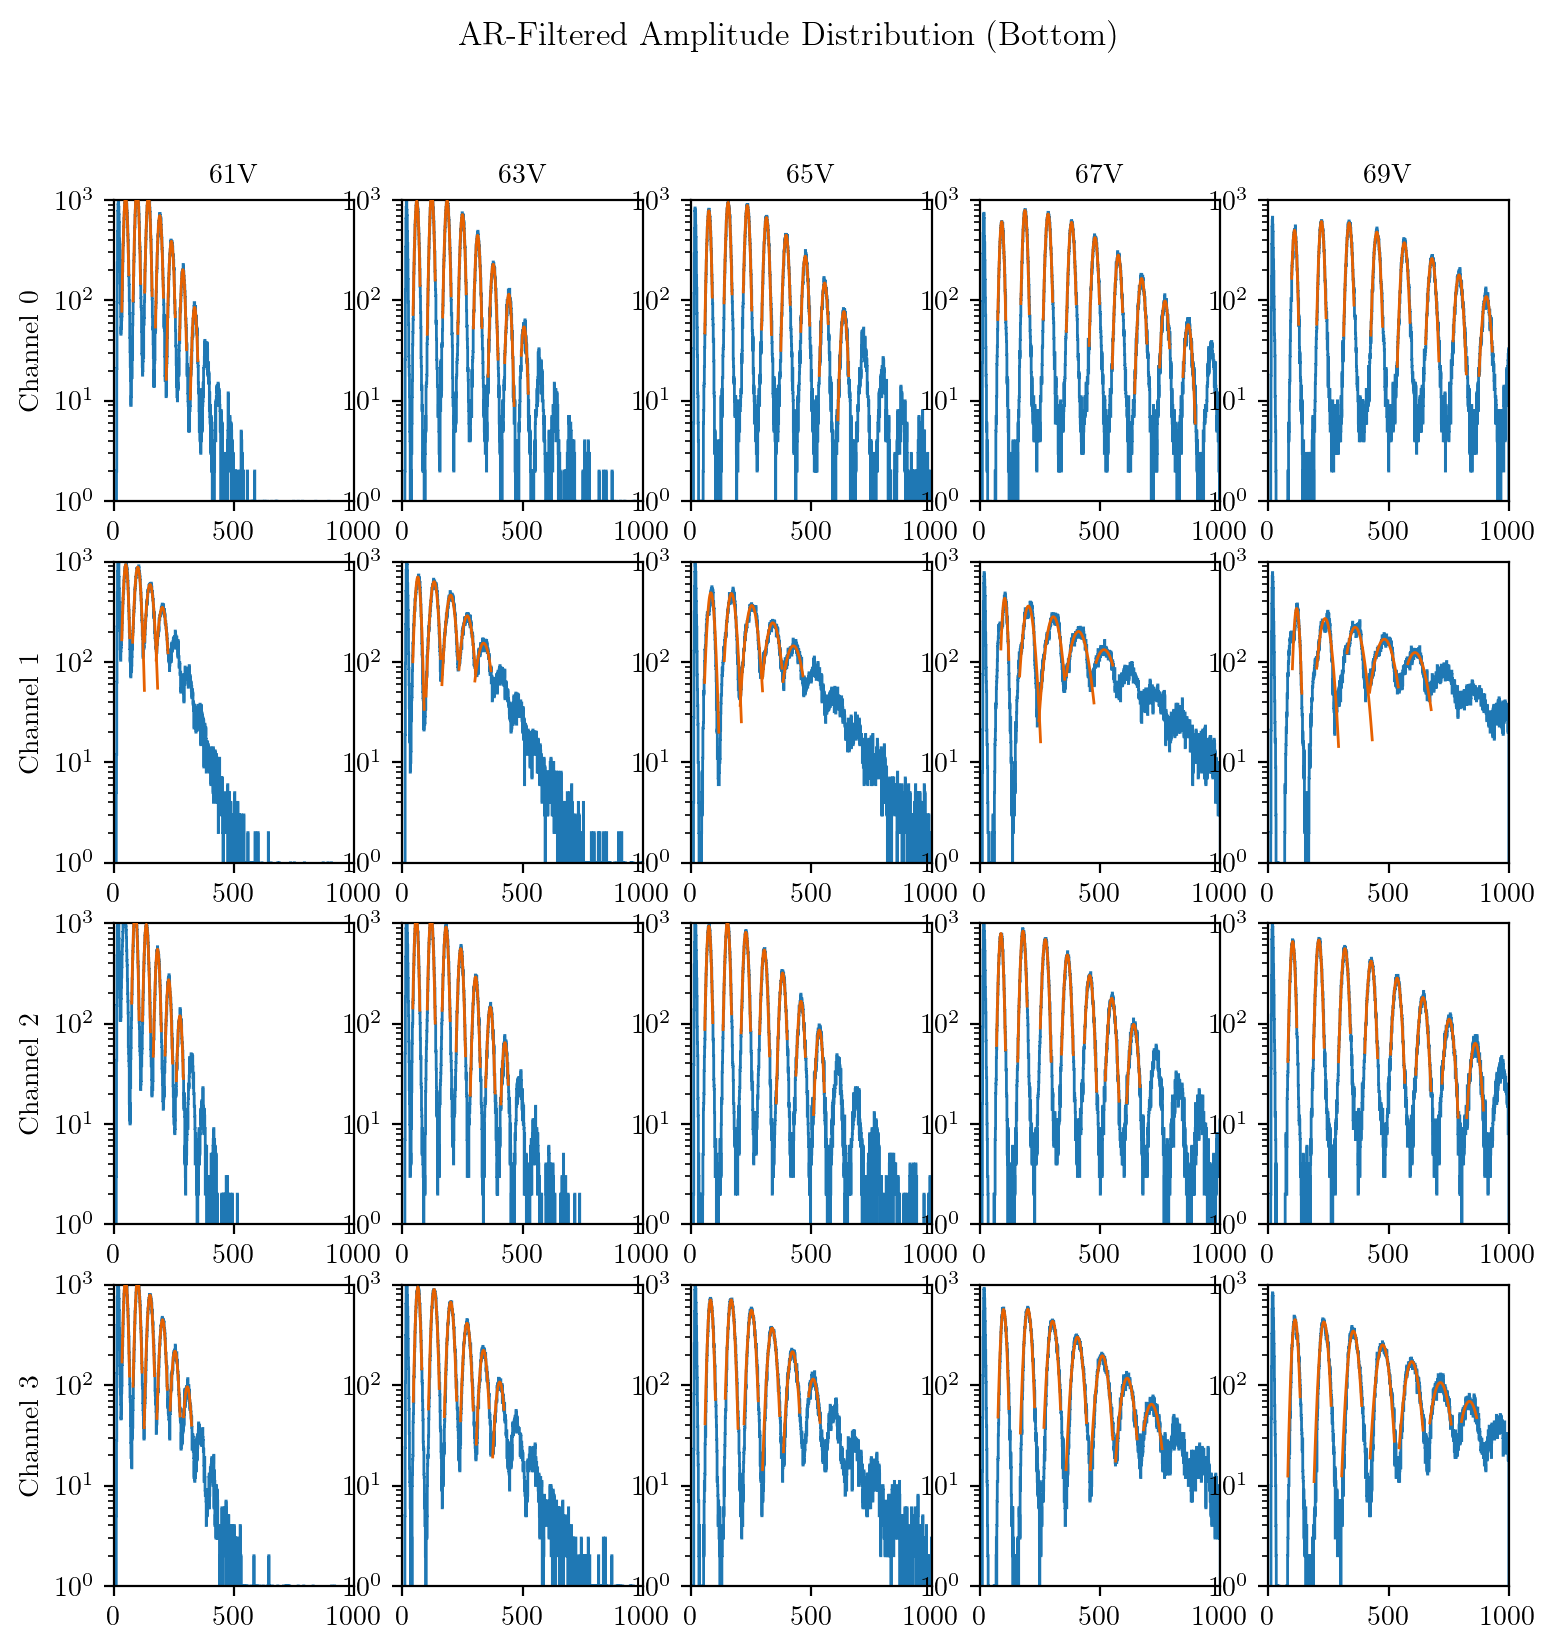

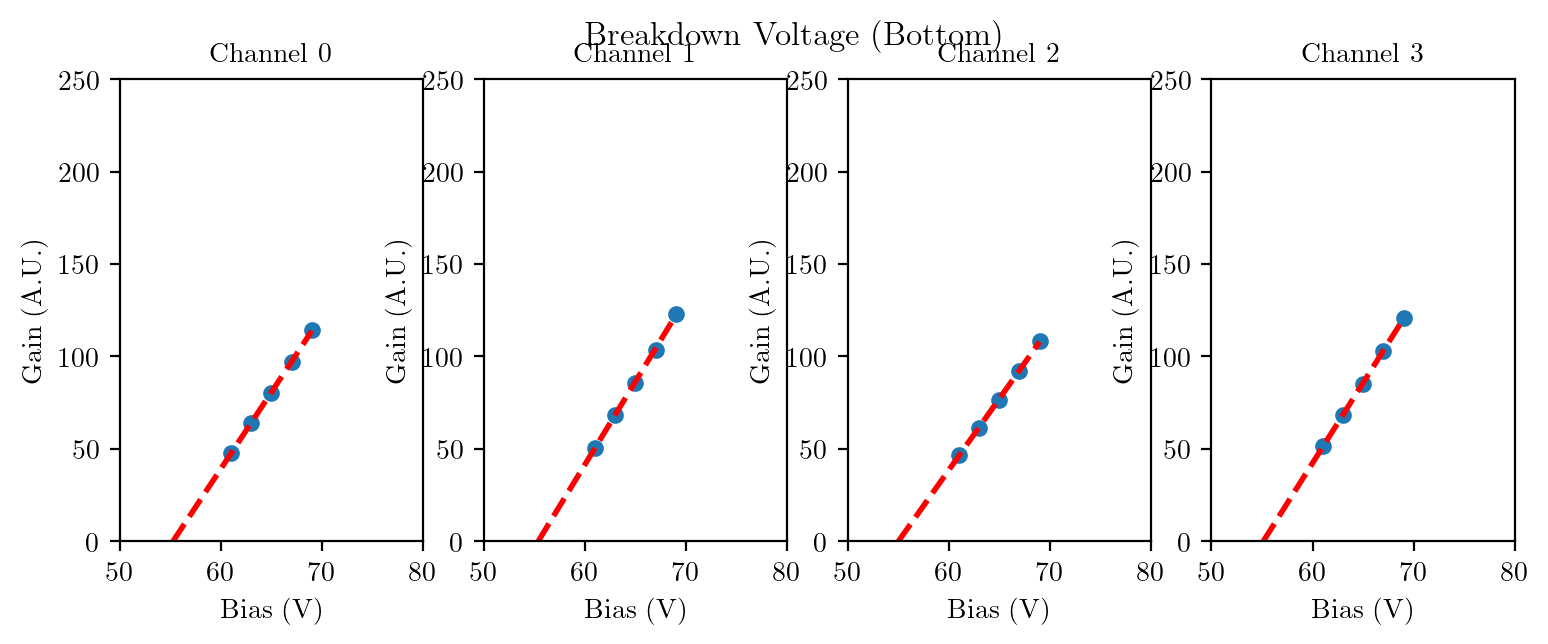

In [13]:
plt.figure(0,figsize=(9,9))#for filtered amplitude histograms
plt.figure(1,figsize=(9,3))#for breakdown voltage fit
bias = [61, 63, 65, 67, 69]
Vbd_famp_bottom = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets):  
        #filtered amplitude histogram
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(0, 1000)
        plt.ylim(1, 1e3)
        # find pe peaks in histogram
        thre = 30
        peaks,pdict = find_peaks(data.ch[ch].famp_hist[thre:], prominence=60, width=15, distance=20)
        #fit pe peaks with Gaussian
        pe_mean = []
        bin_width = data.ch[ch].famp_hist_bin[1]-data.ch[ch].famp_hist_bin[0]
        for ip,peak_bin in enumerate(peaks):
            peak_bin = peak_bin + thre
            pe_width_bin = int(pdict['widths'][ip])
            pe_width_x = bin_width*pe_width_bin
            min_bin = peak_bin-pe_width_bin
            max_bin = peak_bin+pe_width_bin
            min_x = data.ch[ch].famp_hist_bin[0] + bin_width*min_bin
            max_x = data.ch[ch].famp_hist_bin[0] + bin_width*max_bin
            peak_x = data.ch[ch].famp_hist_bin[0] + bin_width*peak_bin
            popt,pcov = curve_fit(gauss, data.ch[ch].famp_hist_bin[min_bin:max_bin], data.ch[ch].famp_hist[min_bin:max_bin], p0=[data.ch[ch].famp_hist[peak_bin], peak_x, pe_width_x], maxfev=10000)
            plt.plot(data.ch[ch].famp_hist_bin[min_bin:max_bin], gauss(data.ch[ch].famp_hist_bin[min_bin:max_bin], *popt), color=colors[1], lw=1, zorder=10)
            pe_mean.append(popt[1])
            if(ip==0):
                data.ch[ch].set_calibration(spe_famp=[popt[1]-2*popt[2],popt[1]+2*popt[2]])
        
        #fit pe-mean vs pe with linear
        xlin = np.linspace(1,len(peaks),len(peaks))
        ylin = pe_mean
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], maxfev=10000)
        data.ch[ch].set_calibration(gain_famp=popt[0])
    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].gain_famp for data in datasets]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_famp_bottom[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.plot(xlin,ylin,'o', markersize=5)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,250)
        
plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Bottom)')
# plt.savefig('../plots/sipm/famp_histo_top_0928.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Bottom)')
# plt.savefig('../plots/sipm/gain_bias_famp_top_0928.pdf')

# Breakdown voltage summary

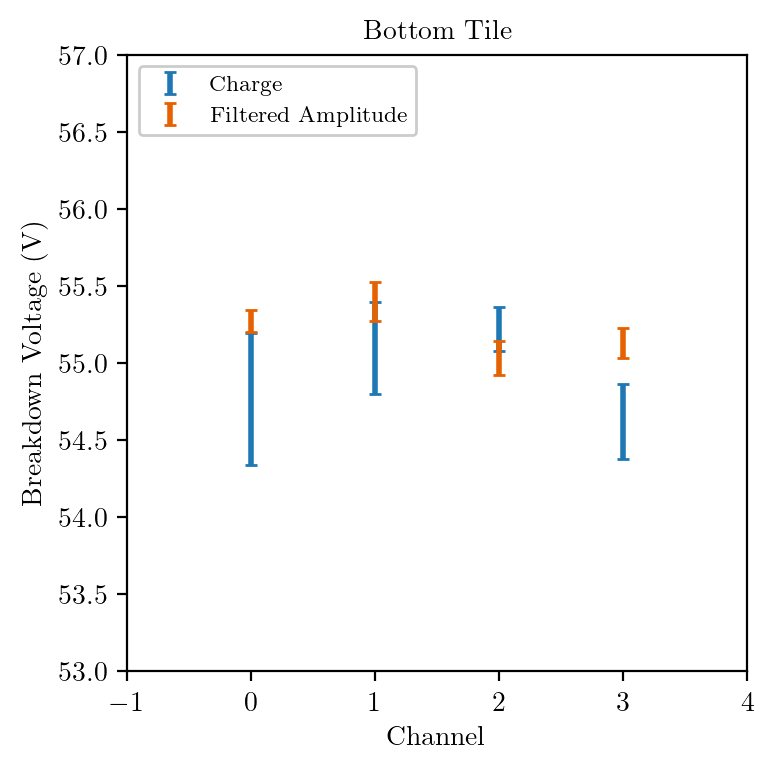

In [14]:
plt.figure(0,figsize=(4,4))
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_charge_bottom[:,0], yerr=Vbd_charge_bottom[:,1], label='Charge', ls='none')
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_famp_bottom[:,0], yerr=Vbd_famp_bottom[:,1], label='Filtered Amplitude', ls='none')
plt.xlim(-1,4)
plt.ylim(53,57)
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage (V)')
plt.title('Bottom Tile')
plt.legend()
plt.show()
# plt.savefig('../plots/sipm/vbd_bottom_0928.pdf')

## SPE average waveform

CH0 61V  A1=2.957 TAU1=0.08486us A2=0.797 TAU2=0.94820us INTEGRAL=251.768
CH0 63V  A1=3.589 TAU1=0.08105us A2=0.854 TAU2=0.97137us INTEGRAL=280.138
CH0 65V  A1=4.459 TAU1=0.07852us A2=1.081 TAU2=0.88407us INTEGRAL=326.536
CH0 67V  A1=5.713 TAU1=0.07517us A2=1.289 TAU2=0.81934us INTEGRAL=371.359
CH0 69V  A1=6.767 TAU1=0.08102us A2=1.487 TAU2=0.76660us INTEGRAL=422.131
CH1 61V  A1=3.603 TAU1=0.10215us A2=0.508 TAU2=1.26238us INTEGRAL=252.324
CH1 63V  A1=4.658 TAU1=0.10029us A2=0.620 TAU2=1.27364us INTEGRAL=314.265
CH1 65V  A1=5.908 TAU1=0.09920us A2=0.631 TAU2=1.39724us INTEGRAL=367.055
CH1 67V  A1=6.838 TAU1=0.10214us A2=0.860 TAU2=1.08353us INTEGRAL=407.556
CH1 69V  A1=7.606 TAU1=0.10269us A2=0.761 TAU2=1.29454us INTEGRAL=441.648
CH2 61V  A1=3.307 TAU1=0.08350us A2=0.498 TAU2=1.25686us INTEGRAL=225.472
CH2 63V  A1=4.141 TAU1=0.08111us A2=0.592 TAU2=1.24232us INTEGRAL=267.928
CH2 65V  A1=5.291 TAU1=0.08158us A2=0.686 TAU2=1.16771us INTEGRAL=308.146
CH2 67V  A1=6.242 TAU1=0.08043us A2=0.

Text(0.5, 0.98, 'SPE Average Waveform (Bottom)')

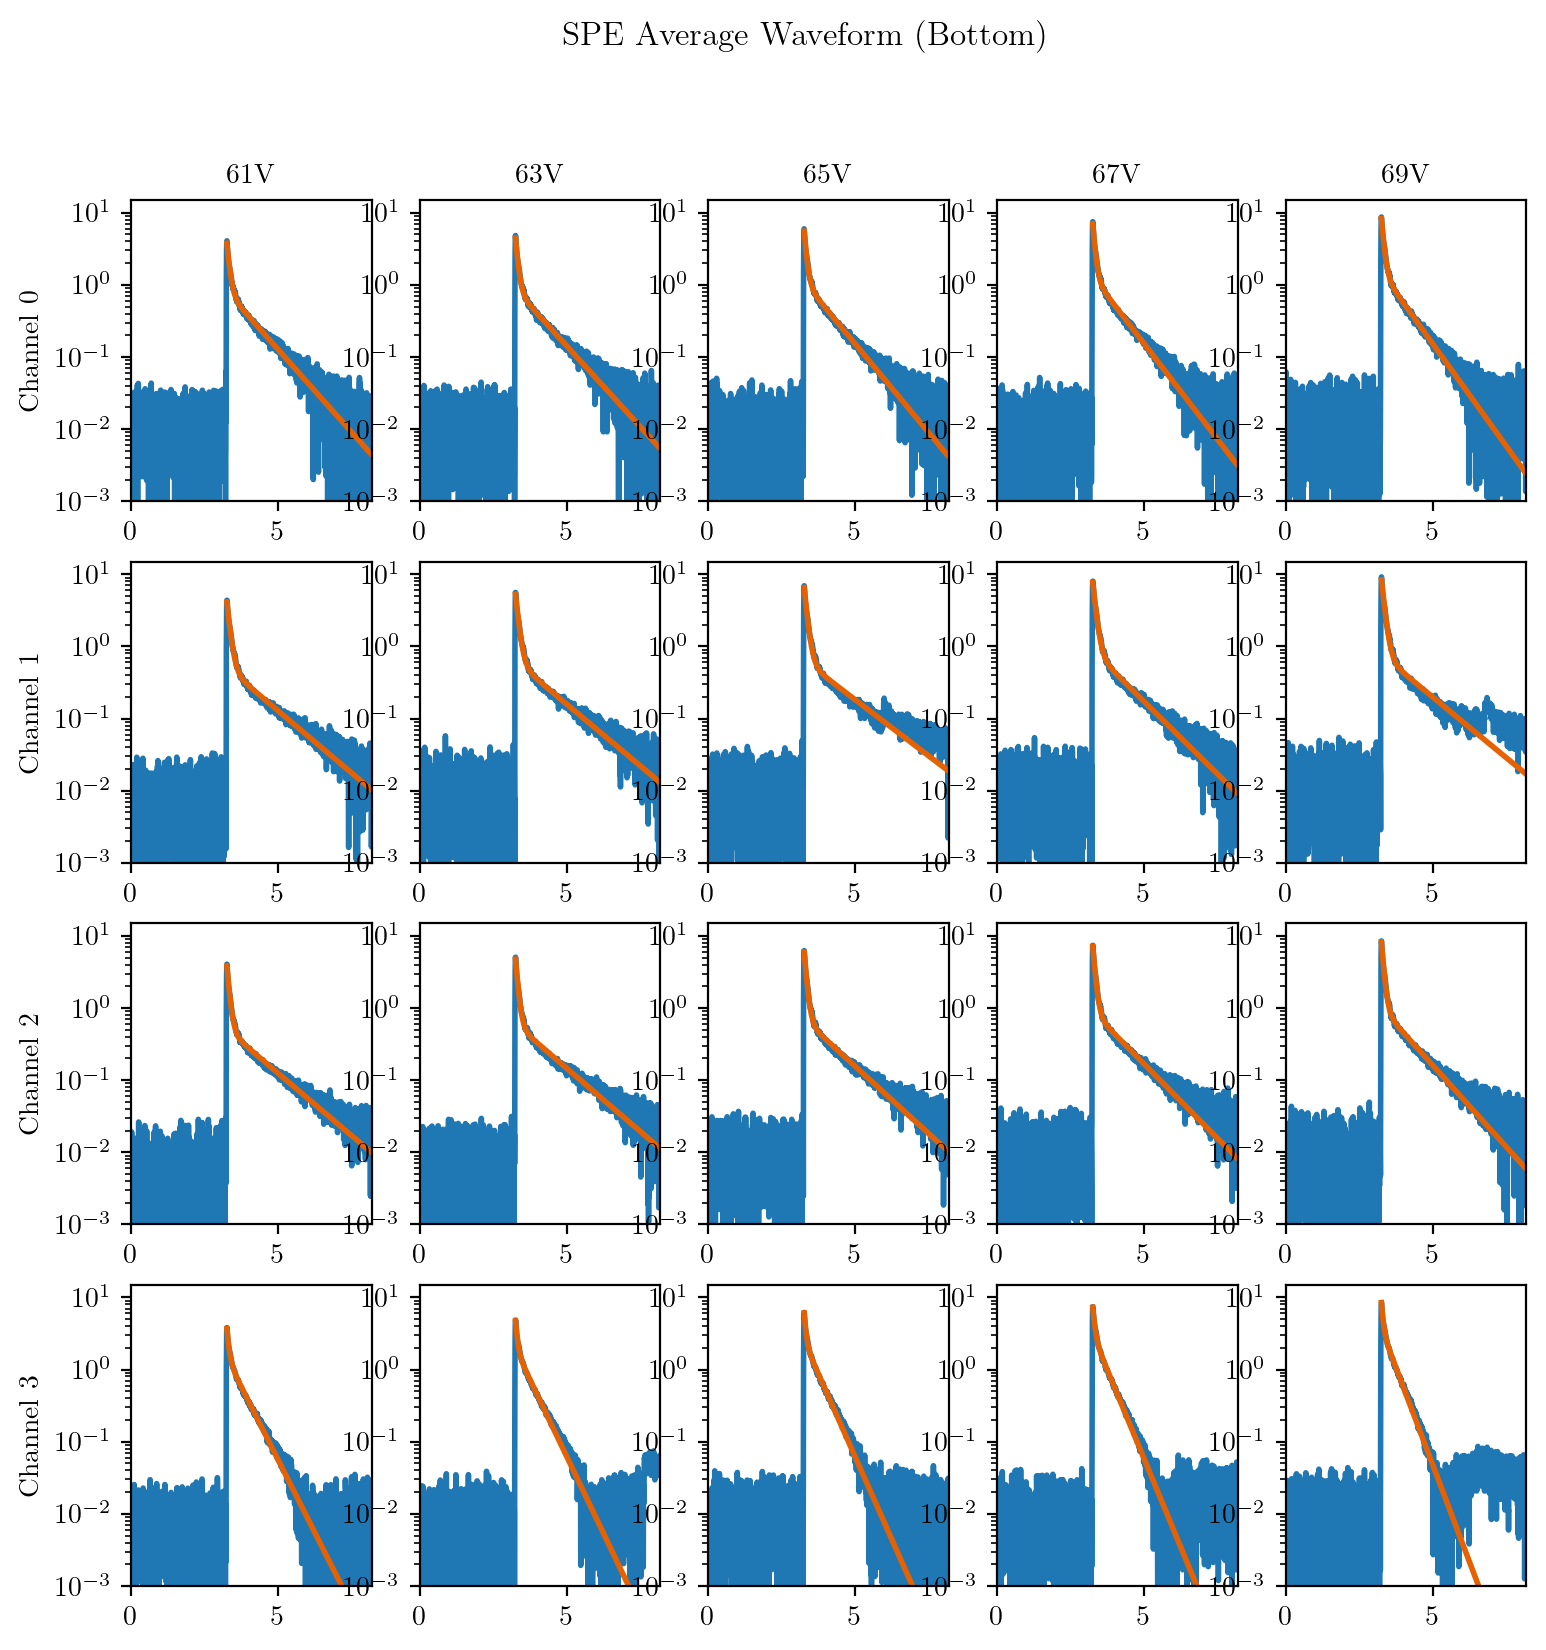

In [15]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))

for ch in [0,1,2,3]:
    for i,data in enumerate(datasets):
        data.ch[ch].get_spe_avgwf()
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(data.ch[ch].time, abs(data.ch[ch].spe_avgwf))
        popt,pcov = curve_fit(data.ch[ch].get_pulse_shape, data.ch[ch].time[data.ch[ch].trigger_position:], data.ch[ch].spe_avgwf[data.ch[ch].trigger_position:], p0=[3,0.08,3,0.5],maxfev=10000)
        plt.plot(data.ch[ch].time[data.ch[ch].trigger_position:], data.ch[ch].get_pulse_shape(data.ch[ch].time[data.ch[ch].trigger_position:],*popt))
        print('CH{} {}V  A1={:.3f} TAU1={:.5f}us A2={:.3f} TAU2={:.5f}us INTEGRAL={:.3f}'.format(ch,bias[i],popt[0],popt[1],popt[2],popt[3],popt[0]*popt[1]*250+popt[2]*popt[3]*250))
        data.ch[ch].set_pulse_shape(*popt)
        plt.xlim(data.ch[ch].time[0],data.ch[ch].time[-1])
        plt.ylim(1e-3, 15)
        plt.yscale('log')
plt.suptitle('SPE Average Waveform (Bottom)')
# plt.savefig('../plots/sipm/spewf_bottom_0928.pdf')